In [1]:
__author__ = "Muhammad Ahmed Rao"
__version__ = "2.0.0"
__maintainer__ = "Muhammad Ahmed Rao"
__email__ = "muhammad.rao@andela.com"

In [76]:
import pandas as pd
import numpy as np
from datetime import date, timedelta


from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score

from matplotlib.pyplot import figure


import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE 

In [3]:
app_record = pd.read_csv('application_record.csv')
credit_record = pd.read_csv('credit_record.csv')

In [4]:
print('Total Application record: ', len(app_record))
print('Total Credit record: ', len(credit_record))

Total Application record:  438557
Total Credit record:  1048575


In [5]:
print('Unique Client Number: ', len(app_record.ID.unique()))
print('Unique Client Number:', len(credit_record.ID.unique()))

Unique Client Number:  438510
Unique Client Number: 45985


In [6]:
merged_df = app_record.merge(credit_record, how='inner', on=['ID'])

In [7]:
print('Length of Merged datasets: ', len(merged_df))
print('Common Client Number between both datasets: ', len(merged_df.ID.unique()))

Length of Merged datasets:  777715
Common Client Number between both datasets:  36457


In [8]:
## check duplicates
print('Duplicates: ', all(merged_df.duplicated()))

Duplicates:  False


By Looking at the EDA reports, no duplicates are found in the data. 
I will now perform following steps:
1. Data Cleaning
2. Feature Engineering
3. Data labeling
4. Split Data in Training and Testing set
5. Train Model and evaluate

    i. Decision Tree
    
    ii. Random Forest
    
    iii. XGBoost

# 1. Data Cleaning

In [9]:
merged_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE',
       'STATUS'],
      dtype='object')

In [10]:
#check null
merged_df.isnull().sum().sort_values(ascending=False)

OCCUPATION_TYPE        240048
STATUS                      0
NAME_FAMILY_STATUS          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_HOUSING_TYPE           0
MONTHS_BALANCE              0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
CNT_FAM_MEMBERS             0
ID                          0
dtype: int64

In [11]:
merged_df['OCCUPATION_TYPE'].value_counts()

Laborers                 131572
Core staff                77112
Sales staff               70362
Managers                  67738
Drivers                   47678
High skill tech staff     31768
Accountants               27223
Medicine staff            26691
Cooking staff             13416
Security staff            12400
Cleaning staff            11399
Private service staff      6714
Low-skill Laborers         3623
Secretaries                3149
Waiters/barmen staff       2557
HR staff                   1686
IT staff                   1319
Realty agents              1260
Name: OCCUPATION_TYPE, dtype: int64

In [12]:
# replacing missing occupation types to Others since we have already a lot of them
merged_df['OCCUPATION_TYPE'].replace(np.nan, 'Others', inplace=True)

In [13]:
merged_df['FLAG_MOBIL'].value_counts()

1    777715
Name: FLAG_MOBIL, dtype: int64

In [14]:
#drop FLAG_MOBIL as it contains only one constant value
merged_df.drop(['FLAG_MOBIL'],axis=1,inplace=True)

# 2. Feature Engineering

In [15]:
# calculate age from Birth day
merged_df['AGE'] = round(merged_df.DAYS_BIRTH / -365.0,2)

In [16]:
#check if applicant is employed?
merged_df['IS_EMPLOYED'] = merged_df.apply(lambda x: 0 if x.DAYS_EMPLOYED > 0 else 1, axis=1)

In [17]:
#fetch start date of employement of an applicant
merged_df['EMPLOYMENT_START_DT'] = merged_df.apply(lambda x: ((date.today() + timedelta(days=x.DAYS_EMPLOYED)).strftime('%Y-%m-%d')) 
                                             if x.DAYS_EMPLOYED <= 0 else None,axis=1)

In [18]:
#how long applicant is employed
merged_df['EMPLOYMENT_YEARS'] = merged_df.apply(lambda x: round(x['DAYS_EMPLOYED'] / -365.0,2) 
                                                if x.DAYS_EMPLOYED < 0 else 0.0, axis=1)

# 3. Data Labelling

In [19]:
status_categories = {'C' : 'Good', 'X' : 'Good', 
                     '0' : 'Good', '1' : 'Good', 
                     '2' : 'Bad', '3' : 'Bad', 
                     '4' : 'Bad', '5' : 'Bad'}

In [20]:
merged_df.STATUS.value_counts()

C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: STATUS, dtype: int64

In [21]:
merged_df.replace({'STATUS' : status_categories}, inplace=True)

In [22]:
merged_df.STATUS.value_counts()

Good    774887
Bad       2828
Name: STATUS, dtype: int64

<AxesSubplot:>

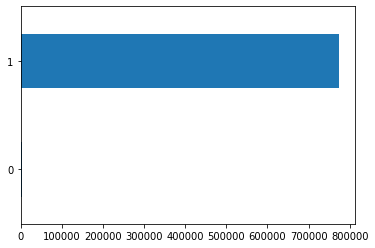

In [90]:
merged_df.TARGET.value_counts().sort_values().plot(kind = 'barh')


0.36% are bad applicants

In [23]:
merged_df.loc[merged_df['STATUS'] == 'Bad', 'TARGET'] = 0
merged_df.loc[merged_df['STATUS'] == 'Good', 'TARGET'] = 1

In [24]:
merged_df['TARGET'] = merged_df['TARGET'].astype(int)

In [25]:
merged_df.TARGET.value_counts()

1    774887
0      2828
Name: TARGET, dtype: int64

In [26]:
categorical_features = [ 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 
                        'NAME_HOUSING_TYPE','OCCUPATION_TYPE']

In [27]:
merged_df = pd.get_dummies(merged_df, columns = categorical_features, drop_first = True)

In [28]:
merged_df.columns

Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'MONTHS_BALANCE', 'STATUS', 'AGE', 'IS_EMPLOYED', 'EMPLOYMENT_START_DT',
       'EMPLOYMENT_YEARS', 'TARGET', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y',
       'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HO

In [29]:
# Drop un-necessary columns
merged_df.drop(['ID', 'EMPLOYMENT_START_DT', 'DAYS_BIRTH', 'STATUS', 'DAYS_EMPLOYED'],axis=1,inplace=True)

In [91]:
x = merged_df.drop(["TARGET"], axis=1)
y = merged_df["TARGET"]

# 4. Split Data in Training and Testing set

In [92]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,test_size = 0.10,random_state = 42)

In [94]:
len(X_test)

77772

# 5. Train Model and evaluate

In [41]:
## re-use the same code for other model any initializing the model
def train_model_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_acc = accuracy_score(y_test, y_pred)
    print('The Accuracy for Test Set is: {}'.format(round(test_acc*100,2)))
    
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)

    plt.figure(figsize=(12,6))
    plt.title('Confusion Matrix')
    sns.heatmap(cnf_matrix, annot=True,fmt='d', cmap='Blues')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    
    return True

i. Decision Tree

In [42]:
model = DecisionTreeClassifier()

The Accuracy for Test Set is: 99.57


True

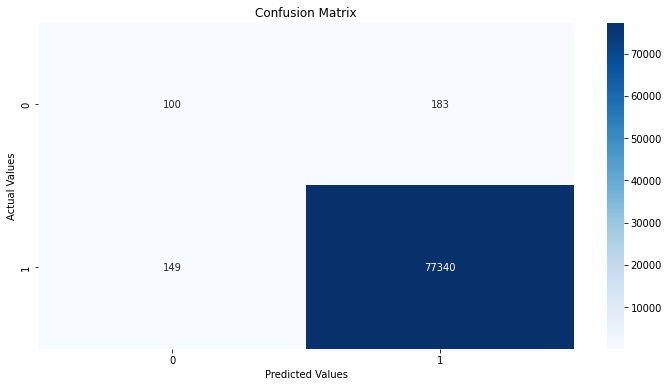

In [43]:
train_model_and_evaluate(model,X_train, y_train, X_test, y_test)

# The problem here is that due to unbalance data the model can not correctly classify if the Applicant is Bad. Let's balance the data using Oversampling technique

In [56]:

ros = RandomOverSampler(random_state=0)

ros.fit(X_train, y_train)
x_oversampled, y_oversampled = ros.fit_resample(X_train,y_train)


The Accuracy for Test Set is: 99.34


True

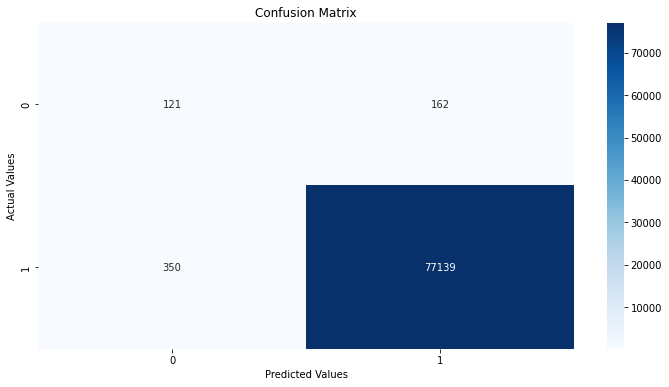

In [57]:
model = DecisionTreeClassifier()
train_model_and_evaluate(model, x_oversampled, y_oversampled, X_test, y_test)

ii. Random Forest

In [58]:
model = RandomForestClassifier(random_state=0)

The Accuracy for Test Set is: 99.35


True

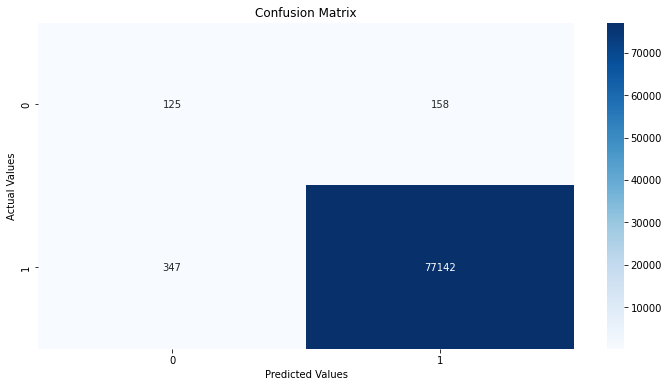

In [59]:
train_model_and_evaluate(model, x_oversampled, y_oversampled, X_test, y_test)

iii. XGBoost

In [50]:
model = XGBClassifier(random_state=0, alpha = 0.5, eta=0.1)

C:\Users\904244\.conda\envs\credit_card\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:39:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy for Test Set is: 94.23


True

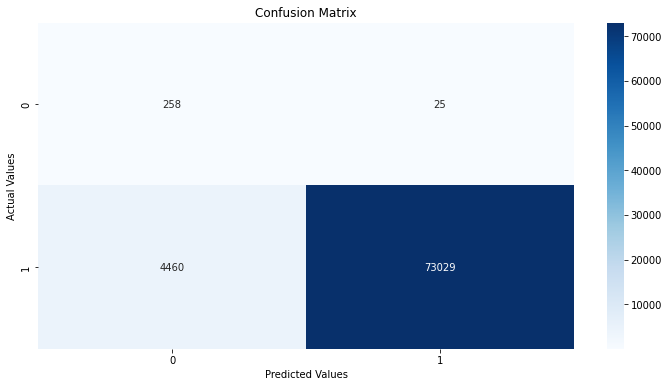

In [51]:
train_model_and_evaluate(model, x_oversampled, y_oversampled, X_test, y_test)

# After oversampling, Decision Tree and Random Forest performed bit well from before. I will  try SMOTE method since it maps minority class by generating synthetic examples rather than by oversampling with replacement. 

In [60]:
smote = SMOTE(random_state=42)
x_oversampled, y_oversampled = ros.fit_resample(x,y)

i. Decision Tree

The Accuracy for Test Set is: 99.56


True

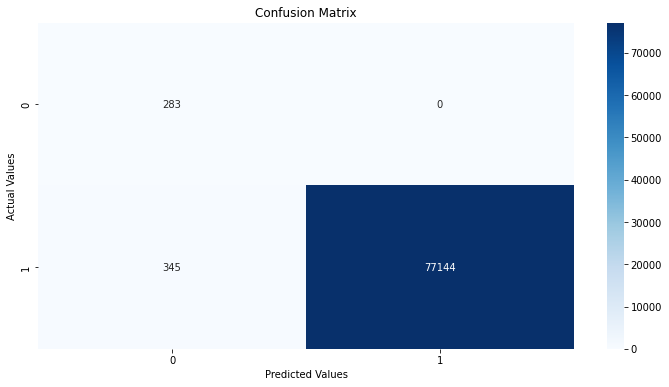

In [69]:
model = DecisionTreeClassifier()
train_model_and_evaluate(model, x_oversampled, y_oversampled, X_test, y_test)

ii. Random Forest

The Accuracy for Test Set is: 99.56


True

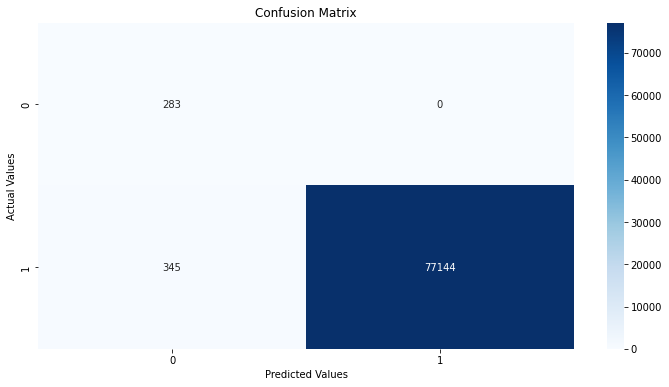

In [71]:
model = RandomForestClassifier(random_state=0)
train_model_and_evaluate(model, x_oversampled, y_oversampled, X_test, y_test)

In [72]:
feautures_importance = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)

Text(0, 0.5, 'Mean decrease in impurity')

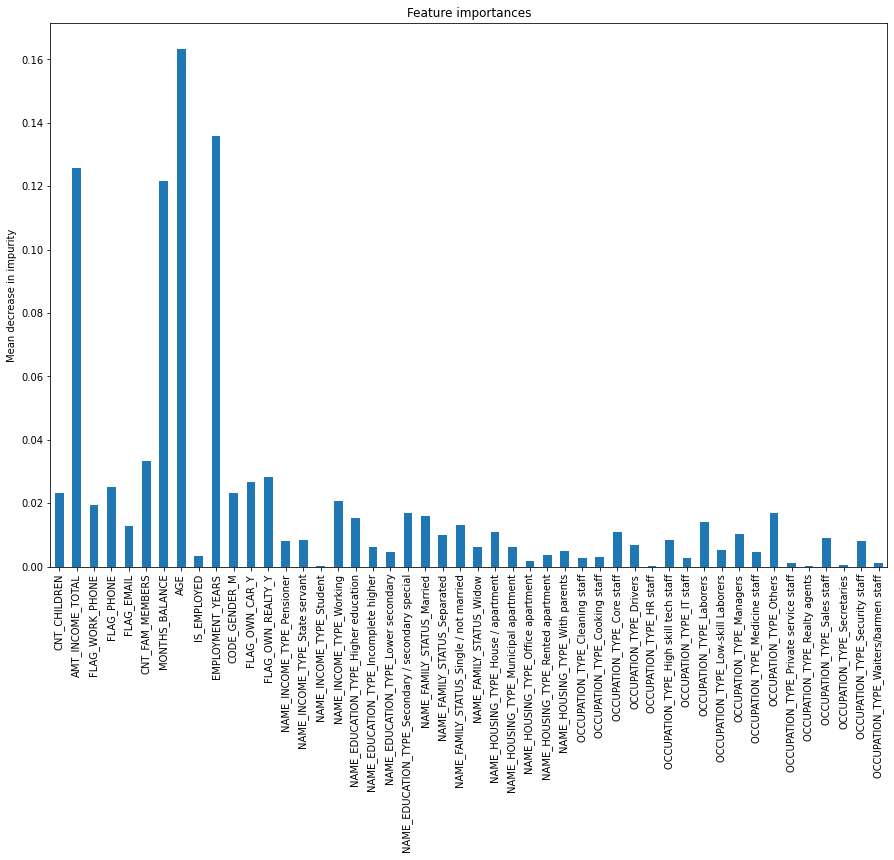

In [85]:
feautures_importance = pd.Series(feautures_importance, index=x_oversampled.columns)

fig, ax = plt.subplots(figsize=(15, 10))
feautures_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")

In [106]:
feautures_importance

CNT_CHILDREN                                         0.023324
AMT_INCOME_TOTAL                                     0.125797
FLAG_WORK_PHONE                                      0.019479
FLAG_PHONE                                           0.025198
FLAG_EMAIL                                           0.012909
CNT_FAM_MEMBERS                                      0.033205
MONTHS_BALANCE                                       0.121560
AGE                                                  0.163340
IS_EMPLOYED                                          0.003292
EMPLOYMENT_YEARS                                     0.135958
CODE_GENDER_M                                        0.023114
FLAG_OWN_CAR_Y                                       0.026810
FLAG_OWN_REALTY_Y                                    0.028367
NAME_INCOME_TYPE_Pensioner                           0.007935
NAME_INCOME_TYPE_State servant                       0.008400
NAME_INCOME_TYPE_Student                             0.000022
NAME_INC

C:\Users\904244\.conda\envs\credit_card\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='CNT_CHILDREN'>

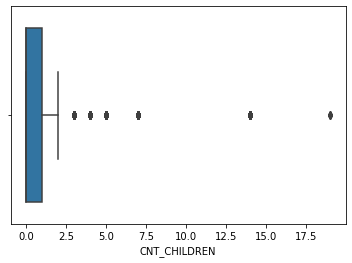

In [117]:
sns.boxplot(merged_df['CNT_CHILDREN'])

C:\Users\904244\.conda\envs\credit_card\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='CNT_CHILDREN'>

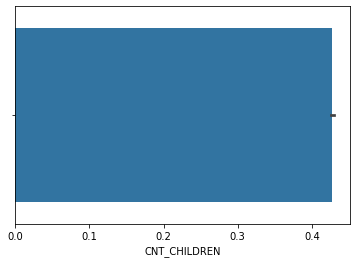

In [116]:
sns.barplot(app_record['CNT_CHILDREN'])

In [119]:
merged_df.columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'AGE', 'IS_EMPLOYED',
       'EMPLOYMENT_YEARS', 'TARGET', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y',
       'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATIO

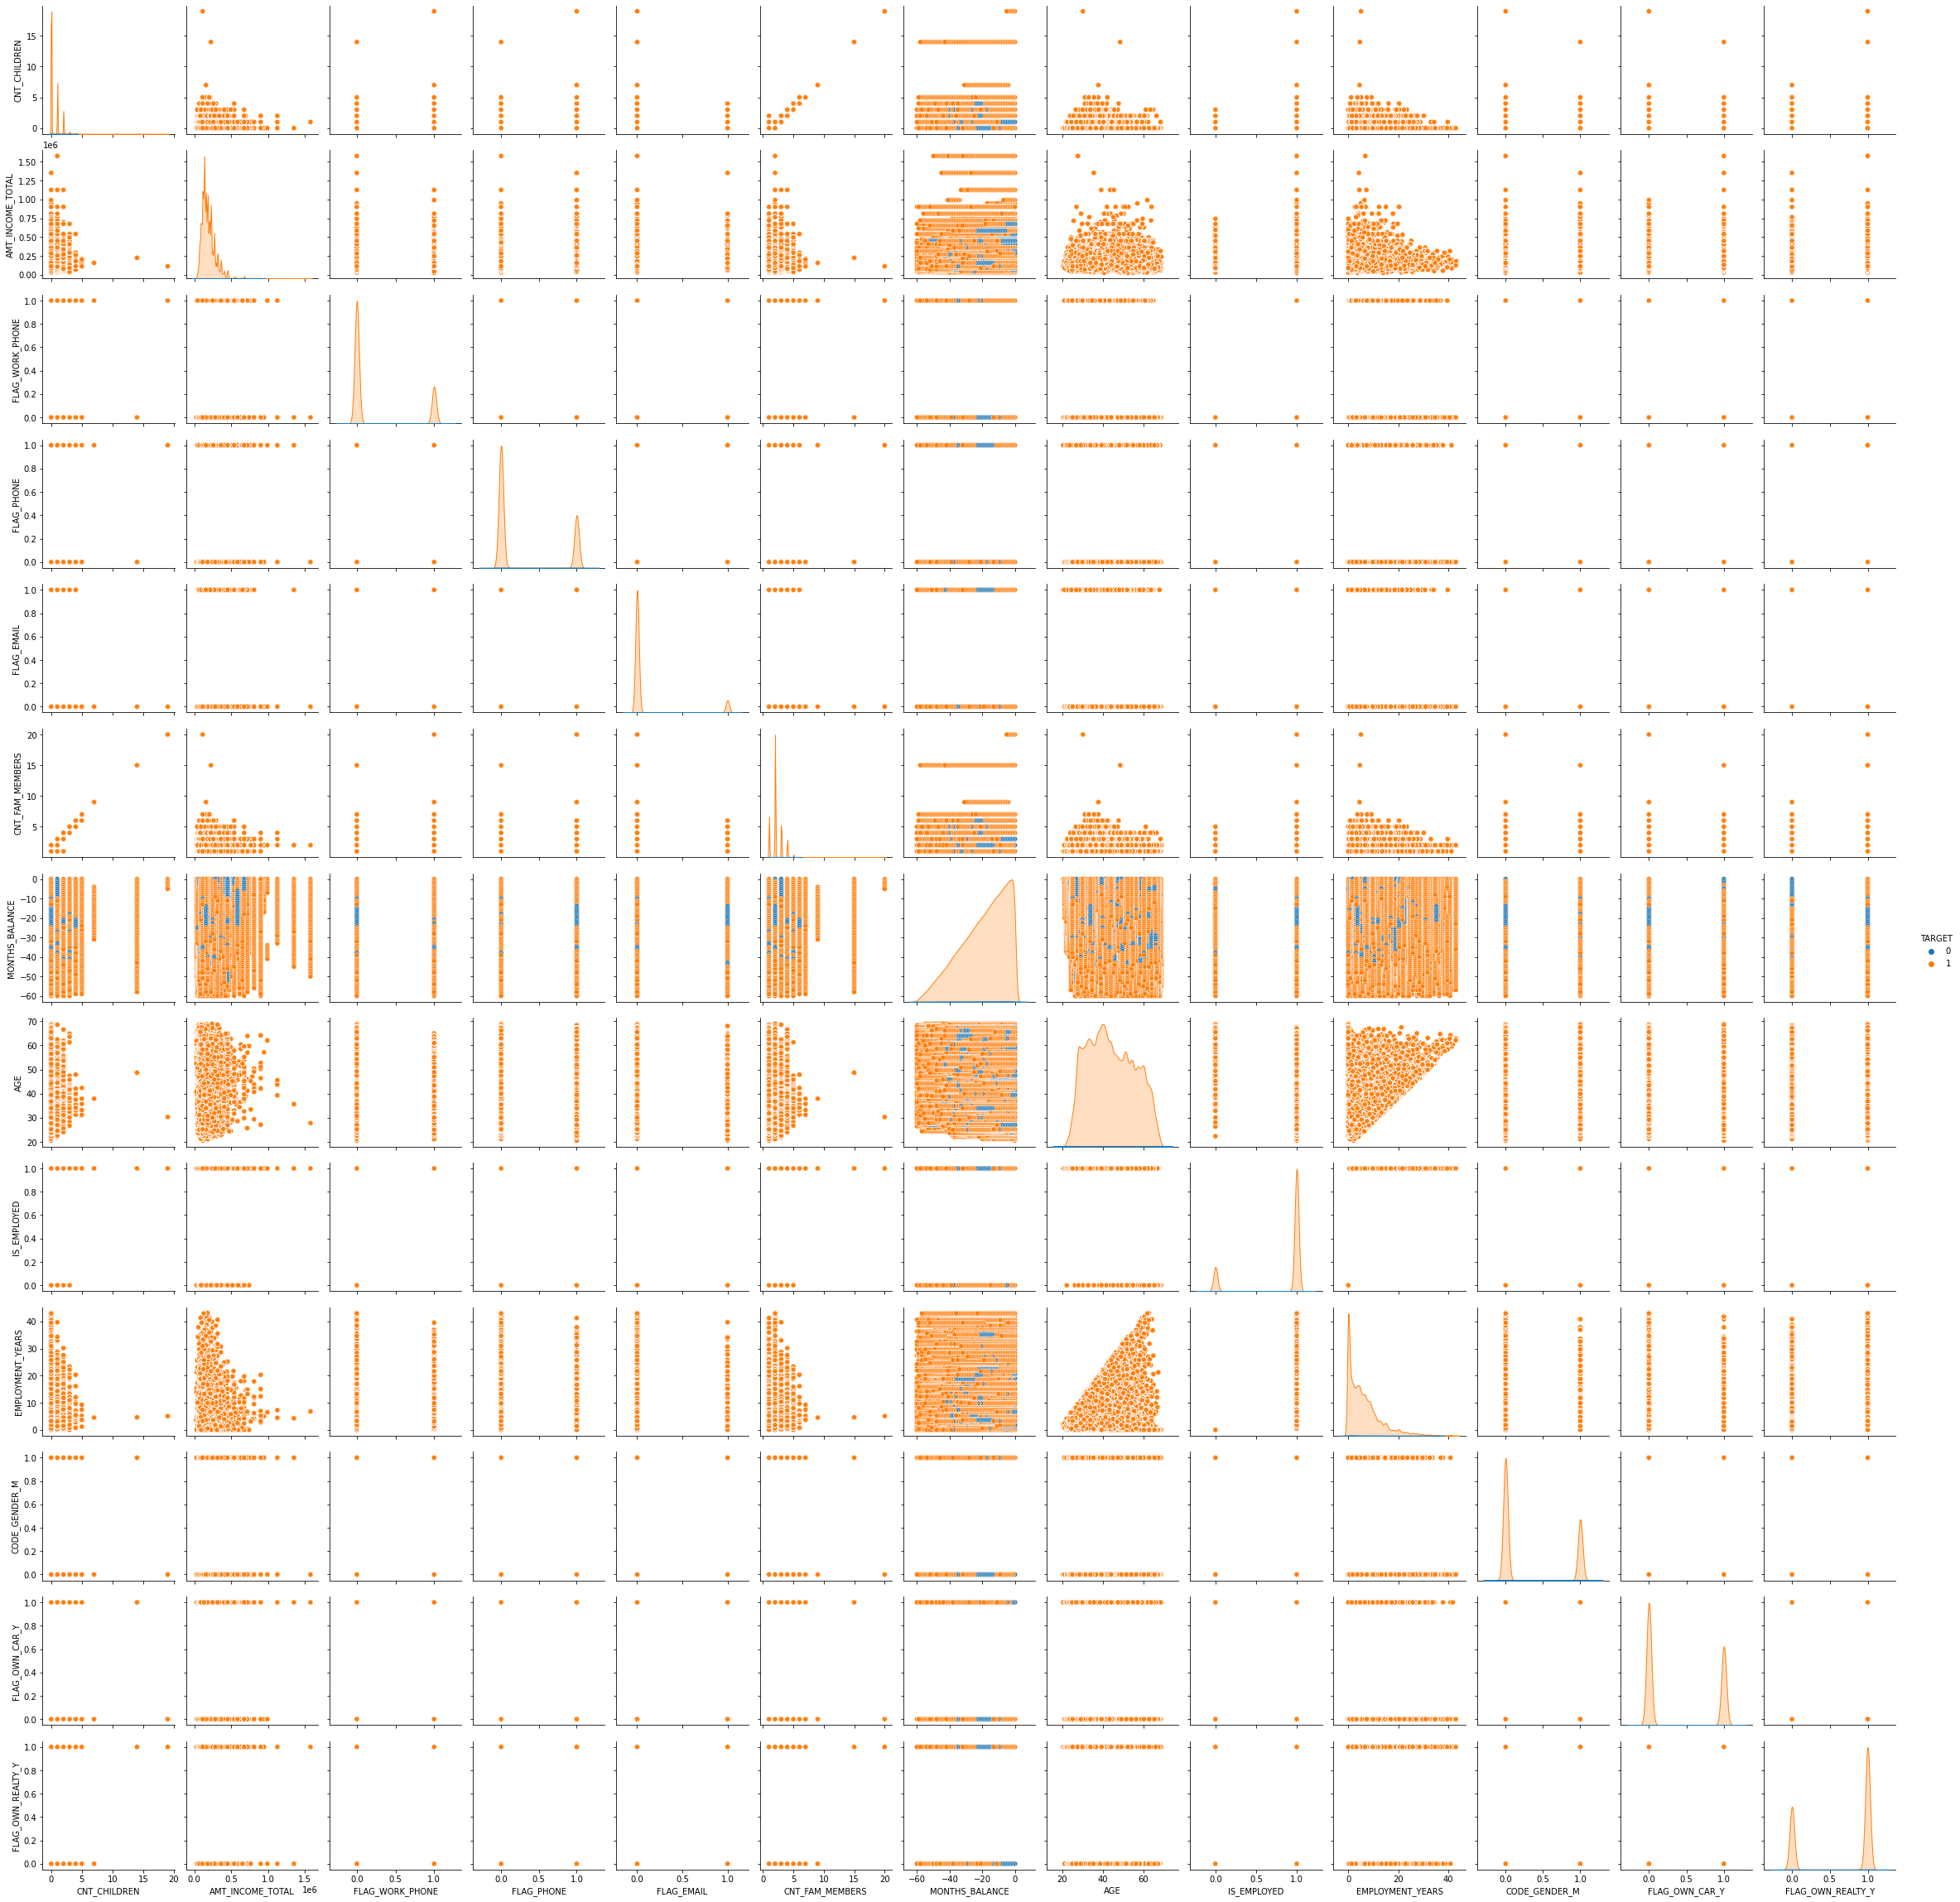

In [120]:
sns.pairplot(data=merged_df[['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'AGE', 'IS_EMPLOYED',
       'EMPLOYMENT_YEARS', 'TARGET', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y',
       'FLAG_OWN_REALTY_Y']], hue='TARGET')

In [121]:
print('1')

1
